Zero-shot classification accuracy: 0.50


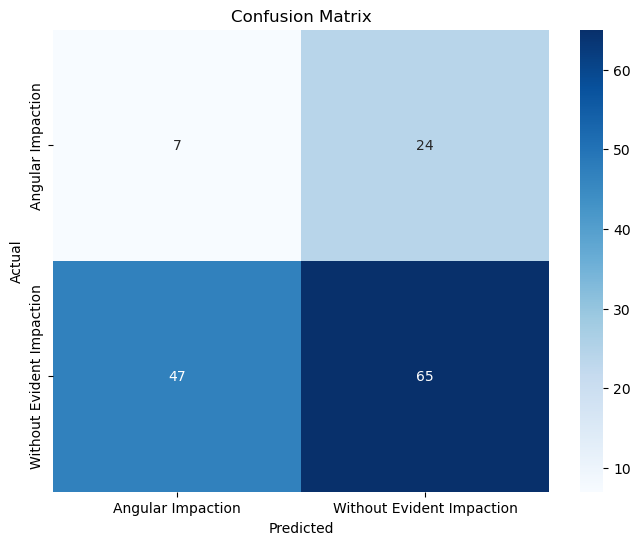

Classification Report:
                           precision    recall  f1-score   support

        Angular Impaction       0.13      0.23      0.16        31
Without Evident Impaction       0.73      0.58      0.65       112

                 accuracy                           0.50       143
                macro avg       0.43      0.40      0.41       143
             weighted avg       0.60      0.50      0.54       143



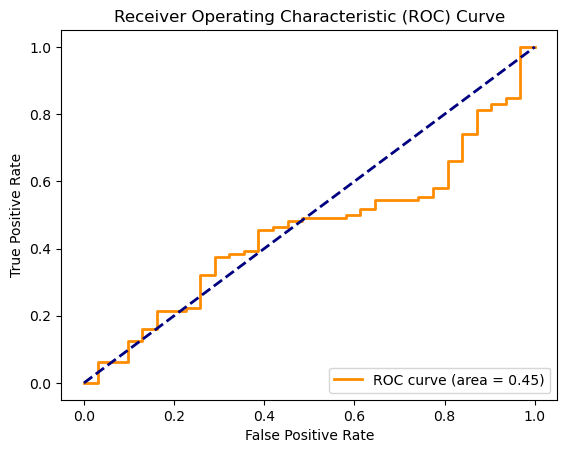

In [7]:
import os
import numpy as np
import torch
import clip
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Load CLIP model and preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)

# Define function to load images and labels from the directory
def load_images_and_labels(directory):
    images = []
    labels = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            label = int(filename.split('_')[1])  # Extract label (0 or 1)
            image_path = os.path.join(directory, filename)
            image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
            images.append(image)
            labels.append(label)
            filenames.append(filename)
    return torch.cat(images), np.array(labels), filenames

# Load train and test sets
train_images, train_labels, train_filenames = load_images_and_labels("D:\\RESEARCH_WORK\\Teeth_Segmentation_Project\\Train")
test_images, test_labels, test_filenames = load_images_and_labels("D:\\RESEARCH_WORK\\Teeth_Segmentation_Project\\Test")

# Define class names
class_names = ['Angular Impaction', 'Without Evident Impaction']

# Function to encode images and texts using CLIP
def encode_images_and_texts(images, class_names):
    with torch.no_grad():
        # Encode the images
        image_features = clip_model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize image features

        # Encode the class names as text
        text_inputs = torch.cat([clip.tokenize(f"an X-ray Showing Image of {name}") for name in class_names]).to(device)
        text_features = clip_model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize text features

    return image_features, text_features

# Encode images and texts
image_features, text_features = encode_images_and_texts(test_images, class_names)

# Perform zero-shot classification by comparing image features with text features
def zero_shot_classification(image_features, text_features):
    similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarities

# Get the similarities for each image
similarities = zero_shot_classification(image_features, text_features)

# Adjust predicted labels based on a similarity threshold
threshold = 0.7  # Set an appropriate threshold based on observations
predicted_labels = [1 if sim[1] > threshold else 0 for sim in similarities.cpu().numpy()]

# Evaluate the results
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Zero-shot classification accuracy: {accuracy:.2f}")

# Generate the confusion matrix and classification report
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, similarities[:, 1])  # Use the similarity for 'Without Evident Impaction'
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
